# Real data comparison

In [17]:
%matplotlib inline

import numpy as np
import scipy.sparse
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.datasets import make_sparse_spd_matrix
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.utils.extmath import squared_norm
from sklearn.covariance import empirical_covariance

from regain import model_selection; reload(model_selection)
from regain.admm import latent_time_graph_lasso_; reload(latent_time_graph_lasso_)
from regain.utils import error_norm

In [19]:
df = pd.read_excel("/home/fede/Desktop/inline-supplementary-material-2.xls", skiprows=1, index_col=0)
best_dims = pd.read_csv("/home/fede/Desktop/inline-supplementary-material-3.txt", delimiter="\t",
                            skiprows=[0,2], skipinitialspace=True)

In [20]:
df.columns = df.columns.str.lower()

In [21]:
best_dims['sum_abs_diff_stress'] = (np.abs(best_dims['cold_2'] - best_dims['cold_3']) + 
    np.abs(best_dims['heat_2'] - best_dims['heat_3']) +
    np.abs(best_dims['oxidative_2'] - best_dims['oxidative_3']))

In [22]:
dims = best_dims.sort_values("sum_abs_diff_stress", ascending=False).head(10)['condition_timepoint'].tolist()

In [23]:
for x in ['shikimic acid-3-phosphate', "methionine", '2-ketobutyric acid']:
    try:
        dims.remove(x)
    except:
        pass

In [24]:
df_reduced = df.loc[:,['time point', 'stress'] + dims].fillna(1)

In [25]:
df_reduced = df_reduced[df_reduced.stress.isin(['cold stress', 'heat stress', 'oxidative stress'])]

In [26]:
a3d = np.array(list(df.groupby("time point").apply(pd.DataFrame.as_matrix)))

df_group = df_reduced.groupby("time point")
max_timepoints = 12
# df_group = df_group.fillna(0)
min_size = int(np.min([g[dims].values.shape[0] for n, g in df_group if n < max_timepoints]))
X = np.array([group[dims].values[:min_size] for name, group in df_group if name < max_timepoints], dtype=float)
# for name, group in df_group:
#     print group.values.astype(float)

In [27]:
data_list = np.log(X.copy())
data_grid = data_list.transpose(1,2,0)

In [28]:
X.shape

(11, 26, 7)

In [33]:
mdl = latent_time_graph_lasso_.LatentTimeGraphLasso(
    alpha=0.2,
    bypass_transpose=False, assume_centered=0, verbose=0, rtol=1e-4, tol=1e-4, psi='l2', phi='l2',
    max_iter=350, rho=1./ np.sqrt(np.array(data_list).shape[1]))

# alpha=np.linspace(0.01, 0.2, 5)
# tau=np.linspace(0.01, 0.8, 5)
# beta=np.linspace(0.01, 0.8, 2)
# eta=np.linspace(0.01, 0.8, 2)
# params = dict(tau=tau, eta=eta, alpha=alpha, beta=beta)

# ltgl = GridSearchCV(mdl, params, cv=ShuffleSplit(3, test_size=.5), verbose=True).fit(data_grid)

domain = [
    {'name': 'tau', 'type': 'continuous', 'domain': (-2, -1)},
#     {'name': 'alpha', 'type': 'continuous', 'domain': (-2.,np.log10(.5))},
    {'name': 'beta', 'type': 'continuous', 'domain': (-2.,np.log10(.5))},
    {'name': 'eta', 'type': 'continuous', 'domain': (-2.,np.log10(.5))},
]
ltgl = model_selection.BayesianOptimization(
    mdl, domain=domain, n_jobs=2, acquisition_weight=1, acquisition_jitter=.01,
    acquisition_type='EI', max_iter=200, cv=ShuffleSplit(5, test_size=.1)).fit(data_grid)

# alpha = ltgl.best_params_['alpha']
tau = ltgl.best_params_['tau']
beta = ltgl.best_params_['beta']
eta = ltgl.best_params_['eta']

In [34]:
import time
tic = time.time()
# ll = ltgl.best_estimator_.fit(data_grid)
ll = mdl.set_params(**ltgl.best_params_).set_params(max_iter=500).fit(data_grid)
tac = time.time()

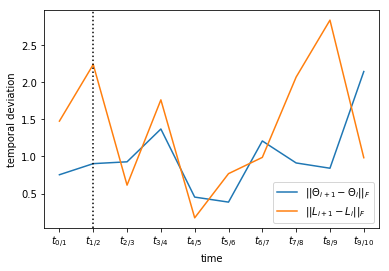

In [35]:
prec = ll.precision_
late = ll.latent_
f = plt.figure()
plt.plot([np.linalg.norm(prec[i+1] - prec[i]) for i in range(prec.shape[0]-1)],
         label=r'$\|\|\Theta_{i+1} - \Theta_i\|\|_F$')
plt.plot([np.linalg.norm(late[i+1] - late[i]) for i in range(late.shape[0]-1)],
         label=r'$\|\|L_{i+1} - L_i\|\|_F$')
plt.axvline(1, ls=':', c='k')
plt.ylabel("temporal deviation");
plt.xlabel("time");
plt.xticks(np.arange(prec.shape[0]-1),
           [r'$t_{%d/%d}$'%(i,i+1) for i in range(prec.shape[0]-1)])
plt.legend();

In [90]:
f.savefig("/home/fede/Dropbox/Latent variables networks/paper formatted/real_data_temporal_deviation.pdf")

In [2]:
data = pd.read_csv("../regain/data/finance.csv", header=0, index_col=0)

In [3]:
n = 8
data_list = np.array([data.loc[:,['AMZN', 'IBM', 'GOOG', 'MSFT','APOL']][i:i+n].values 
             for i in range(1, data.shape[0], n)][:-1])

In [4]:
import datetime
datetime.datetime.strptime('20090824', '%Y%m%d').strftime("%Y-%m")

'2009-08'

In [5]:
gg = [data.loc[:,['AMZN', 'IBM', 'GOOG', 'MSFT','APOL']][i:i+n].index 
             for i in range(1, data.shape[0], n)][:-1]
timestamps = ["/".join(np.unique([datetime.datetime.strptime("%d"%x, '%Y%m%d').strftime("%Y-%m") for x in g]).tolist())
              for g in gg]

In [6]:
data_grid = data_list.transpose(1,2,0)

In [12]:
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from regain import utils; reload(utils)
from regain.admm import time_graph_lasso_; reload(time_graph_lasso_)
from regain.admm import latent_time_graph_lasso_; reload(latent_time_graph_lasso_);

mdl = latent_time_graph_lasso_.LatentTimeGraphLasso(
    alpha=0.5, tau=.2,
    bypass_transpose=False, assume_centered=0, verbose=1, rtol=1e-5, tol=1e-5, psi='node',
    max_iter=500, rho=1. / np.sqrt(np.array(data_list).shape[1])).fit(data_grid)

# ltgl = GridSearchCV(mdl, dict(#tau=[0.25, 0.2, 0.1],
#                              tau=np.linspace(0.01, 0.3, 20),
#                              eta=np.linspace(0.01, 0.3, 5), beta=np.linspace(0.2, 0.5, 5),
#                              #alpha=[0.05, 0.1, 1],
#                              alpha=np.linspace(0.01, 0.2, 5)),
#                     cv=ShuffleSplit(1, test_size=.5), n_jobs=-1).fit(data_grid)

obj: 154.5959, rnorm: 12.7516, snorm: 4.5462,eps_pri: 0.0007, eps_dual: 0.0006
obj: 177.4233, rnorm: 7.1418, snorm: 1.7799,eps_pri: 0.0007, eps_dual: 0.0007
obj: 185.1320, rnorm: 4.1057, snorm: 1.5066,eps_pri: 0.0007, eps_dual: 0.0007
obj: 185.3228, rnorm: 2.8963, snorm: 1.3602,eps_pri: 0.0007, eps_dual: 0.0007
obj: 182.2167, rnorm: 2.8649, snorm: 1.0045,eps_pri: 0.0008, eps_dual: 0.0007
obj: 178.7290, rnorm: 2.8290, snorm: 0.6066,eps_pri: 0.0008, eps_dual: 0.0007
obj: 176.6659, rnorm: 2.4084, snorm: 0.3564,eps_pri: 0.0008, eps_dual: 0.0007
obj: 176.3013, rnorm: 1.9383, snorm: 0.2885,eps_pri: 0.0008, eps_dual: 0.0007
obj: 177.1572, rnorm: 1.5764, snorm: 0.2864,eps_pri: 0.0008, eps_dual: 0.0007
obj: 178.4253, rnorm: 1.3851, snorm: 0.2411,eps_pri: 0.0008, eps_dual: 0.0007
obj: 179.8978, rnorm: 1.2256, snorm: 0.1885,eps_pri: 0.0008, eps_dual: 0.0007
obj: 181.4060, rnorm: 1.0804, snorm: 0.1591,eps_pri: 0.0008, eps_dual: 0.0007
obj: 182.6557, rnorm: 0.9632, snorm: 0.1244,eps_pri: 0.0008, ep

In [13]:
mdl.n_iter_

99

In [14]:
ll = ltgl.best_estimator_

AttributeError: 'LatentTimeGraphLasso' object has no attribute 'best_estimator_'

In [15]:
ll = mdl

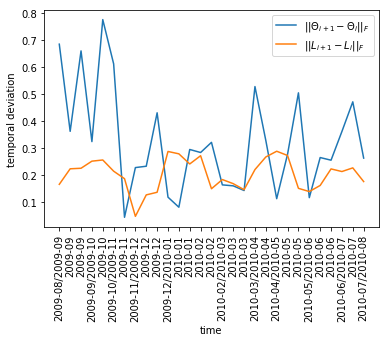

In [18]:
prec = ll.precision_
late = ll.latent_
f = plt.figure()
plt.plot([np.linalg.norm(prec[i+1] - prec[i]) for i in range(prec.shape[0]-1)],
         label=r'$\|\|\Theta_{i+1} - \Theta_i\|\|_F$')
plt.plot([np.linalg.norm(late[i+1] - late[i]) for i in range(late.shape[0]-1)],
         label=r'$\|\|L_{i+1} - L_i\|\|_F$')
plt.ylabel("temporal deviation");
plt.xlabel("time");
plt.xticks(np.arange(prec.shape[0]-1),
           timestamps[:-1], rotation='vertical')
plt.legend();